In [1]:
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#load dataset and labels
datap = '/content/drive/MyDrive/504project/robdataset2.npy'
labelp = '/content/drive/MyDrive/504project/roblabel2.npy'
dataset = np.load(datap)
label = np.load(labelp)
label = label-48


Mounted at /content/drive


In [3]:

print(dataset.shape)
print(max(label))
unique_values = np.unique(label)

# 输出唯一值的数量
num_unique_values = len(unique_values)
print(num_unique_values)



(39163, 1, 20, 20)
42
34


In [4]:
#change nparray to tensor
X_train_tensor = torch.tensor(dataset[:35000,:,:,:], dtype=torch.float32)
y_train_tensor = torch.tensor(label[:35000], dtype=torch.long)
X_test_tensor = torch.tensor(dataset[35000:,:,:], dtype=torch.float32)
y_test_tensor = torch.tensor(label[35000:], dtype=torch.long)
#PADING
X_train_tensor = F.pad(X_train_tensor, (6, 6, 6, 6), mode='constant', value=0)
X_test_tensor = F.pad(X_test_tensor, (6, 6, 6, 6), mode='constant', value=0)


# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 2000)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(2000, 500)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(500, 43)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# create lenet
lenet_model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_model.parameters(), lr=0.001)


Epoch [1/30], Loss: 0.4038, Accuracy: 90.80%
Epoch [2/30], Loss: 0.0630, Accuracy: 98.41%
Epoch [3/30], Loss: 0.0361, Accuracy: 99.17%
Epoch [4/30], Loss: 0.0258, Accuracy: 99.41%
Epoch [5/30], Loss: 0.0186, Accuracy: 99.59%
Epoch [6/30], Loss: 0.0154, Accuracy: 99.65%
Epoch [7/30], Loss: 0.0120, Accuracy: 99.73%
Epoch [8/30], Loss: 0.0101, Accuracy: 99.78%
Epoch [9/30], Loss: 0.0081, Accuracy: 99.83%
Epoch [10/30], Loss: 0.0072, Accuracy: 99.85%
Epoch [11/30], Loss: 0.0065, Accuracy: 99.87%
Epoch [12/30], Loss: 0.0053, Accuracy: 99.90%
Epoch [13/30], Loss: 0.0047, Accuracy: 99.91%
Epoch [14/30], Loss: 0.0042, Accuracy: 99.91%
Epoch [15/30], Loss: 0.0040, Accuracy: 99.93%
Epoch [16/30], Loss: 0.0035, Accuracy: 99.94%
Epoch [17/30], Loss: 0.0036, Accuracy: 99.95%
Epoch [18/30], Loss: 0.0030, Accuracy: 99.96%
Epoch [19/30], Loss: 0.0031, Accuracy: 99.94%
Epoch [20/30], Loss: 0.0027, Accuracy: 99.95%
Epoch [21/30], Loss: 0.0025, Accuracy: 99.95%
Epoch [22/30], Loss: 0.0020, Accuracy: 99.9

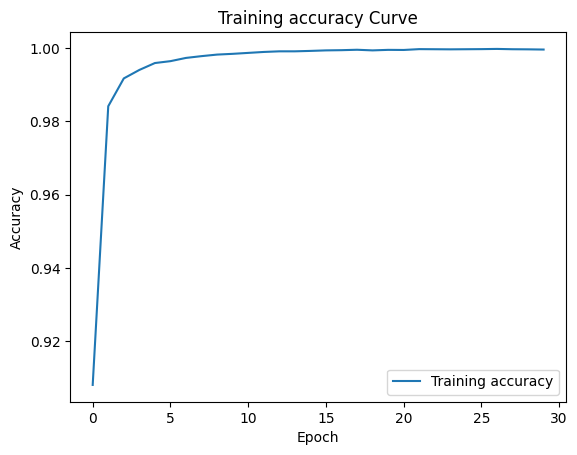

In [10]:

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct_predictions = (predicted == labels).sum().item()
    accuracy = correct_predictions / labels.size(0)
    return accuracy


num_epochs = 30

import matplotlib.pyplot as plt

# Assuming you have a function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct_predictions = (predicted == labels).sum().item()
    accuracy = correct_predictions / labels.size(0)
    return accuracy

# Assuming you have a train_loader DataLoader and lenet_model, criterion, and optimizer defined

train_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = lenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, labels)

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    train_losses.append(average_accuracy)



    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {average_accuracy * 100:.2f}%')

# Plot the loss curve
plt.plot(train_losses, label='Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training accuracy Curve')
plt.show()

In [ ]:
import torch

def test_model_accuracy(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode

    total_accuracy = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            correct_predictions = (predicted == labels).sum().item()

            total_accuracy += correct_predictions
            total_samples += labels.size(0)

    accuracy = total_accuracy / total_samples
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    return accuracy
# Assuming you have already trained your model and defined the test_loader and criterion
test_accuracy = test_model_accuracy(lenet_model, test_loader, criterion)


Test Accuracy: 99.88%


In [ ]:
torch.save(lenet_model, '/content/drive/MyDrive/504project/model_lenetrobnd30.pth')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('/content/drive/MyDrive/504project/model_lenet.pth')  # 加载模型
model = model.to(device)
model.eval()  # 把模型转为test模式

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=43, bias=True)
)

In [ ]:
outputs = model(inputs)
 _, predicted = torch.max(outputs, 1)